Workflow:
1. Build all the blank BTO models (6x6 x-y, variety of thicknesses)
2. Three model categories: BTO, BZO, BZT40
3. Insert clusters into each model at varying heights (Ti clusters for BZO, Zr clusters for BTO, and both for BZT40
4. Simulate the images
5. Analyze w/ SO + stats
6. Vizualize

In [1]:
import pickle
from datetime import datetime
from copy import deepcopy
from pathlib import Path
from random import seed
from ase.visualize import view
from ase.io import write
# Only import reload if one of the custom libraries is modified while the notebook is running, otherwise it messes up pickle
#from importlib import reload
import numpy as np
from ase import Atoms

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r"\usepackage{libertine}"
%matplotlib widget
import matplotlib.pyplot as plt
import graphical
# reload(graphical)
import abtem_backend as backend
#reload(backend)
import ase_funcs
#reload(ase_funcs)
import SingleOrigin as so
#reload(so)

In [2]:
base_models = backend.build_from_cif(graphical.gui_get_path(),
                                     zas=(1, 0, 0),
                                     tks=[20, 40, 80, 120],
                                     tilings=(9, 9))

In [3]:
view(base_models[0].atoms)

<Popen: returncode: None args: ['C:\\Users\\charles\\.jupyter\\venv\\Scripts...>

In [5]:
bto_models = deepcopy(base_models)  # A bit memory inefficient, but prevents any mutation weirdness with the base models
bzo_models = [backend.Model(ase_funcs.randomize_chem(mod.atoms, {"Ti": {"Zr": 1}}), 4.083, 4.083, 4.083, (1, 0, 0), tks)
              for mod, tks in zip(base_models, [m.thickness for m in base_models])]
bzt_seeds = [5657, 86771, 17315, 72170, 42288, 47240, 33929]
# bzt_seeds = [22873, 60083, 80155, 30434, 76279, 87195, 49904]  # Truly random seeds from random.org
bzt_models_zr_cluster = [backend.Model(ase_funcs.randomize_chem(mod.atoms, {"Ti": {"Zr": 0.4}}, prseed=seed), 4.083, 4.083, 4.083, (1, 0, 0), tks)
              for seed, (mod, tks) in zip(bzt_seeds, zip(base_models, [m.thickness for m in base_models]))]
bzt_models_ti_cluster = deepcopy(bzt_models_zr_cluster)  # Differentiation in next cell

I'm going to simulate the different cluster positions in different runs, for two reasons:
1. These are big models, so not doing all of the simulations in one run will allow some analysis to happen in parallel
2. It will let me confirm that things are, in general, working as expected before I commit to simulating all of the models
3. Figuring out how I want to do the centered-cluster simulations will be a little annoying, so I'm putting it off for the moment

In [6]:
# This is, admittedly, an inelegant way to do this, but it's simple and by far fast enough
# Also: setting the atoms this way means I don't need to put the chopped columns back into the models!
#  They get updated automatically when set at the atom level!

# For 3x3 inside 9x9: cols[30:33] + cols[39:42] + cols[48:51]
# For 4x4 inside 12x12: cols[52:56] + cols[64:68] + cols[76:80] + cols[88:92]


for model in bto_models:
    cols = ase_funcs.split_by_projected_columns(model.atoms, "Ti")
    cols = sorted(cols, key=lambda x: x[0].index)
    working_cols = cols[30:33] + cols[39:42] + cols[48:51]
    # Low indices --> bottom, high indices --> top
    for col in working_cols:
        switch = col[-3:]
        for atom in switch:
            atom.symbol = "Zr"

for model in bzo_models:
    cols = ase_funcs.split_by_projected_columns(model.atoms, "Zr")
    cols = sorted(cols, key=lambda x: x[0].index)
    working_cols = cols[30:33] + cols[39:42] + cols[48:51]
    # Low indices --> bottom, high indices --> top
    for col in working_cols:
        switch = col[-3:]
        for atom in switch:
            atom.symbol = "Ti"

for model in bzt_models_zr_cluster:
    cols = ase_funcs.split_by_projected_columns(model.atoms, ["Ti", "Zr"])
    cols = sorted(cols, key=lambda x: x[0].index)
    working_cols = cols[30:33] + cols[39:42] + cols[48:51]
    # Low indices --> bottom, high indices --> top
    for col in working_cols:
        switch = col[-3:]
        for atom in switch:
            atom.symbol = "Zr"

for model in bzt_models_ti_cluster:
    cols = ase_funcs.split_by_projected_columns(model.atoms, ["Ti", "Zr"])
    cols = sorted(cols, key=lambda x: x[0].index)
    working_cols = cols[30:33] + cols[39:42] + cols[48:51]
    # Low indices --> bottom, high indices --> top
    for col in working_cols:
        switch = col[-3:]
        for atom in switch:
            atom.symbol = "Ti"

In [7]:
view(bto_models[0].atoms)

<Popen: returncode: None args: ['C:\\Users\\charles\\.jupyter\\venv\\Scripts...>

My simulations are coming out looking absolutely wacky, and all of my efforts at troubleshooting have failed, so I'm just going to export the models and run them one at a time through Dr Probe...

In [8]:
outpath = graphical.gui_get_path(is_file=False)
# for model in bto_models:
#     fname = "bto_" + str(model.thickness) + "_topcluster.xyz"
#     write(outpath / fname, model.atoms, format="xyz")
#
# for model in bzo_models:
#     fname = "bzo_" + str(model.thickness) + "_topcluster.xyz"
#     write(outpath / fname, model.atoms, format="xyz")

for model in bzt_models_zr_cluster:
    fname = "bzt_" + str(model.thickness) + "_topcluster_Zr_v2.xyz"
    write(outpath / fname, model.atoms, format="xyz")

# for model in bzt_models_ti_cluster:
#     fname = "bzt_" + str(model.thickness) + "_topcluster_Ti.xyz"
#     write(outpath / fname, model.atoms, format="xyz")


In [7]:
pickle_loc = graphical.gui_get_path(is_file=False)
pickle_name = f"simulation_{int(datetime.now().timestamp())}_PRISIM_9x9_HAADF_topcluster.pkl"
results = []
with open(Path(r"C:\Users\charles\Documents\GitHub\abtem_scripts\true_random_seeds_x108.txt")) as infile:
    seeds = [int(line.rstrip("\n")) for line in infile]

db = backend.DetectorBuilder()

probe_parameters = backend.ProbeParameters(device="gpu",
                                           storage="gpu",
                                           convergence=17.9,
                                           defocus=20,
                                           stig=7, stig_rot=2.7,
                                           coma=335, coma_rot=2.7,
                                           spherical=-5200,
                                           max_batch=1000)

# For 45 simulations, this took just about exactly 1hr to run
for i, model in enumerate(bto_models + bzt_models_zr_cluster):
    # Warning: reusing this name, be careful of running this out of order
    potential_parameters = backend.PotentialParameters(sampling=0.08,
                                                       slice_thickness=1,
                                                       device="cpu",
                                                       storage="cpu",
                                                       precalculate=True,
                                                       fp_cfgs=1000,
                                                       fp_sigmas={"Ba": 0.0757,
                                                                  "Ti": 0.0893,
                                                                  "Zr": 0.1050,
                                                                  "O":  0.0810},
                                                       seed=seeds[i])
    results.append(backend.sim_stem([model],
                                    db,
                                    potential_prms=potential_parameters,
                                    probe_prms=probe_parameters,
                                    kinds=["flex"],
                                    devnum=1))
    with open(pickle_loc / pickle_name, "w+b") as picklefile:
        pickle.dump(results, picklefile)  # Dump the cumulative results to a file after each run, just in case

C:\Users\charles\.jupyter\venv\lib\site-packages\numba\cuda\dispatcher.py:538: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


KeyboardInterrupt: 

In [3]:
unpickle_file = graphical.gui_get_path(is_file=True)
with open(unpickle_file, "rb") as upf:
    results = pickle.load(upf)

In [4]:
imgs = []
for result in results:
    res = result[0]  # Unwrap single element list
    meas = res.measurement[0]
    img = meas.interpolate(tuple([x / 4 for x in res.grid.sampling]), kind="fft").array
    img = so.image_norm(img)
    imgs.append(img)

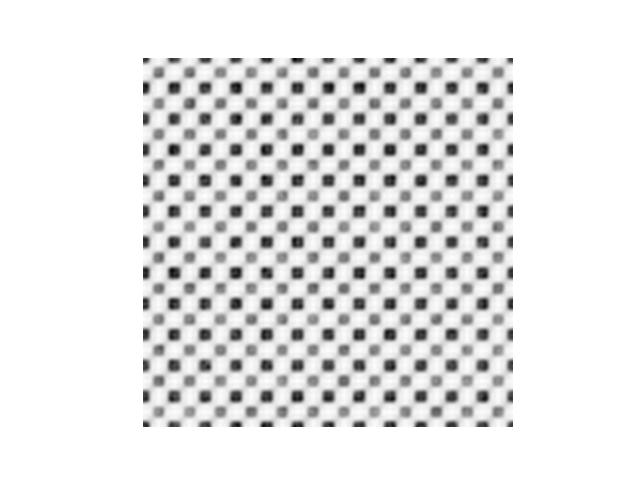

In [7]:
# Preview one of the images, if desired
plt.clf()
plt.imshow(imgs[27], cmap="binary")
plt.axis("off")
plt.show()

Legacy code follows: